
# Cleaning The Data

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

Common data cleaning steps on all text:

- Make text all lower case
- Remove punctuation
- Remove numerical values
- Remove common non-sensical text (/n)
- Tokenize text
- Remove stop words

More data cleaning steps after tokenization:

- Stemming / lemmatization
- Parts of speech tagging
- Create bi-grams or tri-grams
- Deal with typos
- And more...


In [1]:
import pandas as pd

from twitter_scraper import settings

USER_COLS = [
    'user_id',
    'screen_name',
    'verified',
    'location'
]

TWEET_COLS = [
    'id',
    'created_at',
    'week',
    'month',
    'user_id',
    'user_mentions',
    'hashtags',
    'langid',
    'full_text',
    'stemmed',
    'clean_stem',
    'retweet_from_user_id',
    'retweet_from_tweet_id',
]

users_df = pd.read_csv(settings.USERS_CSV).drop_duplicates(subset='user_id')
user_idx = users_df[['user_id', 'screen_name']].set_index('user_id').to_dict()['screen_name']

tweets_df = pd.read_csv(settings.TWEETS_CSV.replace('tweets.csv', 'tweets-text-processed.csv'), low_memory=False)
tweets_df['stemmed'] = tweets_df['stemmed'].map(eval)
tweets_df['clean_stem'] = tweets_df['clean_stem'].map(eval)
tweets_df['user_mentions'] = tweets_df['user_mentions'].map(eval)
df = users_df[USER_COLS].merge(tweets_df[TWEET_COLS], on='user_id', validate='1:m')

In [2]:
# user_tweets_df = df[['screen_name', 'stemmed']].groupby('screen_name').sum()
most_tweeting_users = df.screen_name.value_counts()[:20].index

In [3]:
import re
import gensim

processing_df = df.loc[df[df.screen_name.isin(most_tweeting_users)].index]
processing_df['stemmed'] = processing_df['stemmed'].transform(lambda x: list(filter(None, x)))

URL_REGEX = r'https?:\/\/[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
MENTIONS_REGEX = r'@[A-Za-z0-9-_]+'
RT_MENTIONS_REGEX = r'rt @[A-Za-z0-9-_:]+'
processing_df['full_text_processed'] = processing_df['full_text'].fillna('').transform(str.lower)
processing_df['full_text_processed'] = processing_df['full_text_processed'].transform(lambda x: re.sub(URL_REGEX, '', x))
processing_df['full_text_processed'] = processing_df['full_text_processed'].transform(lambda x: re.sub(RT_MENTIONS_REGEX, '', x))
processing_df['full_text_processed'] = processing_df['full_text_processed'].transform(lambda x: re.sub(MENTIONS_REGEX, '', x))
processing_df['full_text_processed'] = processing_df['full_text_processed'].transform(gensim.utils.simple_preprocess)
processing_df['full_text_processed'] = processing_df['full_text_processed'].transform(lambda x: [y for y in x if y not in stop_words])

data_words = processing_df['full_text_processed'].tolist()
bigrams = gensim.models.Phrases(
    sentences=data_words,
    min_count=5,
    threshold=100
)

bigram_model = bigrams.freeze()

trigrams = gensim.models.Phrases(
    sentences=bigrams[data_words],
    min_count=5,
    threshold=100
)


In [4]:
print(list(trigrams[bigrams[data_words]])[:50])

['big_tech', 'dell_esercito', 'dell_esercito_ucraino', 'john_ioannidis', 'anthony_fauci', 'check_out', 'quello_che', 'julian_assange', 'war_crimes', 'more_than', 'high_representative', 'foreign_affairs', 'school_closures', 'con_la', 'german_chancellor', 'th_century', 'natural_gas', 'la_verità', 'contro_la', 'ursula_von', 'der_leyen', 'ursula_von_der_leyen', 'liz_truss', 'ha_fatto', 'chi_ha', 'detto_che', 'vladimir_putin', 'gli_usa', 'sempre_più', 'nancy_pelosi', 'makes_sense', 'cold_war', 'il_ministro', 'degli_esteri', 'dell_ucraina', 'non_ci', 'investigation_into', 'covid_vaccines', 'european_union', 'please_unroll', 'climate_change', 'nord_stream', 'talking_about', 'so_much', 'hunter_biden', 'joe_biden', 'white_house', 'una_nuova', 'alex_jones', 'last_night']


In [5]:
processing_df['bigrams'] = processing_df['full_text_processed'].transform(lambda x: bigram_mod[x])
processing_df['trigrams'] = processing_df['full_text_processed'].transform(lambda x: trigram_mod[x])

In [3]:
%env CUDA_VISIBLE_DEVICES=2
import classla
import stanza

from twitter_scraper.utils import fileio

stop_words_eng = fileio.read_content(settings.STOP_WORDS_ENG, 'json')
stop_words_hrv = fileio.read_content(settings.STOP_WORDS_HRV, 'json')
# Because of the way our dataset is limited, we are assuming
# we can allow to concatenate english and croatian stop words
stop_words = stop_words_eng + stop_words_hrv 

nlps = {
    'en': stanza.Pipeline('en', use_gpu=settings.CLASSLA_USE_GPU, logging_level='ERROR'),
    'hr': classla.Pipeline('hr', use_gpu=settings.CLASSLA_USE_GPU, logging_level='ERROR'),
    'sr': classla.Pipeline('sr', use_gpu=settings.CLASSLA_USE_GPU, logging_level='ERROR'),
    'sl': classla.Pipeline('sl', use_gpu=settings.CLASSLA_USE_GPU, logging_level='ERROR')
}
nlps['bs'] = nlps['hr']

env: CUDA_VISIBLE_DEVICES=2
[WARNING] 2022-11-07 07:27:20 discord.client - PyNaCl is not installed, voice will NOT be supported


In [1]:
def get_lemmatized_text(row, upos=['NOUN', 'ADJ']):
    if row['langid'] in ('hr', 'bs', 'sr', 'sl'):
        nlp = nlps[row['langid']]
    else:
        nlp = nlps['en']
        
    if not row['bigrams']: 
        return []
    
    doc = nlp(" ".join(row['bigrams']))
    return [word.lemma for sentence in doc.sentences for word in sentence.words if word.upos in upos]

# processing_df.iloc[0]
# processing_df['trigram_stems'] = processing_df.apply(get_lemmatized_text, axis=1)

In [4]:
import pandas as pd
import gensim
import datetime as dt
from twitter_scraper import settings

processing_df = pd.read_csv(settings.TWEETS_CSV.replace('tweets.csv', 'processing_df.csv'), low_memory=False)
processing_df['created_at'] = pd.to_datetime(processing_df['created_at'])
processing_df = processing_df.loc[
    (processing_df['screen_name'] == 'DNEVNIKhr')
    & (processing_df['created_at'] > dt.datetime(2022, 10, 1, 0, 0, 0, tzinfo=dt.timezone.utc))
]
processing_df['bigrams'] = processing_df['bigrams'].map(eval)
processing_df['bigram_stems'] = processing_df.apply(get_lemmatized_text, axis=1)
processing_df

,user_id,screen_name,verified,location,id,created_at,week,month,user_mentions,hashtags,...,full_text,stemmed,clean_stem,retweet_from_user_id,retweet_from_tweet_id,full_text_processed,bigrams,trigrams,trigram_stems,bigram_stems
82831,80316128,DNEVNIKhr,True,Republic of Croatia,1581952890016387073,2022-10-17 10:18:54+00:00,2022-42,2022-10,[],['dnevnikhr'],...,"""HDZ-ovi dužnosnici pijani mogu napadati, nagu...","['HDZ', 'dužnosnik', 'pijan', 'napadati', 'nag...","['HDZ', 'dužnosnik', 'pijan', 'napadati', 'nag...",NaN,NaN,"['hdz', 'ovi', 'dužnosnici', 'pijani', 'mogu',...","[hdz, ovi, dužnosnici, pijani, mogu, napadati,...","['hdz', 'ovi', 'dužnosnici', 'pijani', 'mogu',...","['HDZ', 'ovaj', 'dužnosnik', 'pijan', 'moći', ...","[dužnosnik, pijan, vrat, građanin, posljedica]"
82832,80316128,DNEVNIKhr,True,Republic of Croatia,1581952649544761344,2022-10-17 10:17:57+00:00,2022-42,2022-10,[1288788320],['dnevnikhr'],...,I dalje oduševljava. #dnevnikhr @golhr\nhttps:...,"['daleko', 'oduševljavati', 'dnevnikhr']","['daleko', 'oduševljavati', 'dnevnikhr']",NaN,NaN,"['dalje', 'oduševljava', 'dnevnikhr']","[dalje, oduševljava, dnevnikhr]","['dalje', 'oduševljava', 'dnevnikhr']","['daleko', 'oduševljavati', 'dnevnikhr']",[dnevnikhr]
82833,80316128,DNEVNIKhr,True,Republic of Croatia,1581942847162314753,2022-10-17 09:39:00+00:00,2022-42,2022-10,[],['dnevnikhr'],...,Broj korisnika je u stalnom porastu. #dnevnikh...,"['broj', 'korisnik', 'stalan', 'porast', 'dnev...","['broj', 'korisnik', 'stalan', 'porast', 'dnev...",NaN,NaN,"['broj', 'korisnika', 'je', 'stalnom', 'porast...","[broj, korisnika, je, stalnom, porastu, dnevni...","['broj', 'korisnika', 'je', 'stalnom', 'porast...","['broj', 'korisnik', 'biti', 'stalan', 'porast...","[broj, korisnik, stalan, porast]"
82834,80316128,DNEVNIKhr,True,Republic of Croatia,1581935547991216129,2022-10-17 09:10:00+00:00,2022-42,2022-10,[1288788320],['dnevnikhr'],...,Policija smirivala situaciju. #dnevnikhr @golh...,"['policija', 'smirivati', 'situacija', 'dnevni...","['policija', 'smirivati', 'situacija', 'dnevni...",NaN,NaN,"['policija', 'smirivala', 'situaciju', 'dnevni...","[policija, smirivala, situaciju, dnevnikhr]","['policija', 'smirivala', 'situaciju', 'dnevni...","['policija', 'smirivati', 'situacija', 'dnevni...","[policija, situacija]"
82835,80316128,DNEVNIKhr,True,Republic of Croatia,1581934034665414656,2022-10-17 09:03:59+00:00,2022-42,2022-10,[],['dnevnikhr'],...,Oko Otoka Svibovskog. #dnevnikhr\nhttps://t.co...,"['otoka', 'svibovskog', 'Dnevnikhr']","['otoka', 'svibovskog', 'Dnevnikhr']",NaN,NaN,"['oko', 'otoka', 'svibovskog', 'dnevnikhr']","[oko, otoka, svibovskog, dnevnikhr]","['oko', 'otoka', 'svibovskog', 'dnevnikhr']","['oko', 'otoka', 'svibovskog', 'Dnevnikhr']",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86671,80316128,DNEVNIKhr,True,Republic of Croatia,1582627611154550785,2022-10-19 07:00:00+00:00,2022-42,2022-10,[],"['dnevnikhr', 'ukraine']",...,Hoće li Putinova vlast izdržati vojne poraze? ...,"['putin', 'vlast', 'izdržati', 'vojni', 'poraz...","['putin', 'vlast', 'izdržati', 'vojni', 'poraz...",NaN,NaN,"['hoće', 'li', 'putinova', 'vlast', 'izdržati'...","[hoće, li, putinova, vlast, izdržati, vojne, p...","['hoće_li', 'putinova', 'vlast', 'izdržati', '...","['hoćestao', 'putin', 'vlast', 'izdržati', 'vo...","[putin, vlast, vojni, poraz]"
86672,80316128,DNEVNIKhr,True,Republic of Croatia,1582622574957236228,2022-10-19 06:40:00+00:00,2022-42,2022-10,[],['dnevnikhr'],...,Kraljevska obitelj se još uvijek nije oglasila...,"['kraljevski', 'obitelj', 'oglasiti', 'dnevnik...","['kraljevski', 'obitelj', 'oglasiti', 'dnevnik...",NaN,NaN,"['kraljevska', 'obitelj', 'se', 'još', 'uvijek...","[kraljevska, obitelj, se, još, uvijek, nije, o...","['kraljevska', 'obitelj', 'se', 'još', 'uvijek...","['kraljevski', 'obitelj', 'sebe', 'još', 'uvij...","[kraljevski, obitelj]"
86673,80316128,DNEVNIKhr,True,Republic of Croatia,1582617541939146753,2022-10-19 06

In [5]:
# Create Corpus
texts = processing_df['bigram_stems'].transform(lambda x: list(filter(lambda y: y is not None and y not in stop_words, x))).to_list()
texts = [text for text in texts if len(text) > 0]
# Create Dictionary
id2word = gensim.corpora.Dictionary(texts)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

[INFO] 2022-11-07 07:28:51 gensim.corpora.dictionary - adding document #0 to Dictionary<0 unique tokens: []>
[INFO] 2022-11-07 07:28:51 gensim.corpora.dictionary - built Dictionary<1792 unique tokens: ['dužnosnik', 'građanin', 'pijan', 'posljedica', 'vrat']...> from 1086 documents (total 3864 corpus positions)
[INFO] 2022-11-07 07:28:51 gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary<1792 unique tokens: ['dužnosnik', 'građanin', 'pijan', 'posljedica', 'vrat']...> from 1086 documents (total 3864 corpus positions)", 'datetime': '2022-11-07T07:28:51.720318', 'gensim': '4.2.0', 'python': '3.8.10 (default, Jun 22 2022, 20:18:18) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-124-generic-x86_64-with-glibc2.29', 'event': 'created'}


[INFO] 2022-11-07 07:28:52 gensim.models.ldamodel - using symmetric alpha at 0.1
[INFO] 2022-11-07 07:28:52 gensim.models.ldamodel - using symmetric eta at 0.1
[INFO] 2022-11-07 07:28:52 gensim.models.ldamodel - using serial LDA version on this node
[INFO] 2022-11-07 07:28:52 gensim.models.ldamulticore - running online LDA training, 10 topics, 10 passes over the supplied corpus of 1086 documents, updating every 94000 documents, evaluating every ~1086 documents, iterating 50x with a convergence threshold of 0.001000
[INFO] 2022-11-07 07:28:52 gensim.models.ldamulticore - training LDA model using 47 processes
[INFO] 2022-11-07 07:28:58 gensim.models.ldamulticore - PROGRESS: pass 0, dispatched chunk #0 = documents up to #1086/1086, outstanding queue size 1
[INFO] 2022-11-07 07:28:58 gensim.models.ldamodel - topic #9 (0.100): 0.011*"sat" + 0.010*"dinamo" + 0.010*"dan" + 0.010*"mjesec" + 0.010*"ukrajina" + 0.010*"osoba" + 0.008*"TV" + 0.008*"hrvatski" + 0.008*"europa" + 0.008*"nov"
[INFO] 2

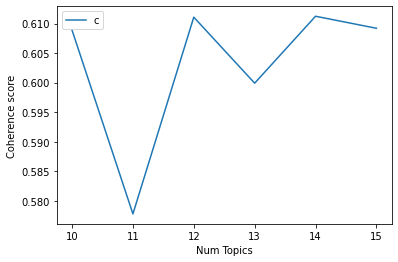

In [6]:
import matplotlib.pyplot as plt

start=10; limit=16; step=1;
coherence_values = []
model_list = []
for num_topics in range(start, limit, step):
    model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10)
    model_list.append(model)
    coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
# plt.savefig('Coh_plot_new_10_02_22.png')
plt.show()

In [7]:
from pprint import pprint
pprint(model_list[2].print_topics())

[INFO] 2022-11-07 07:40:26 gensim.models.ldamodel - topic #0 (0.083): 0.061*"sat" + 0.042*"TV" + 0.028*"dnevnikučnova" + 0.021*"nov" + 0.021*"dnevnik" + 0.012*"istraga" + 0.010*"zemlja" + 0.010*"velik" + 0.009*"oružje" + 0.008*"poskupljenje"
[INFO] 2022-11-07 07:40:26 gensim.models.ldamodel - topic #1 (0.083): 0.019*"prosvjed" + 0.014*"hrvatski" + 0.013*"predsjednik" + 0.011*"ruski" + 0.010*"snaga" + 0.009*"sumnja" + 0.009*"okolnost" + 0.009*"građanin" + 0.008*"ukrajinski" + 0.007*"euro"
[INFO] 2022-11-07 07:40:26 gensim.models.ldamodel - topic #2 (0.083): 0.046*"osoba" + 0.029*"dan" + 0.014*"eksplozija" + 0.013*"dnevnik" + 0.013*"ukrajina" + 0.010*"hrvatski" + 0.009*"emisija" + 0.009*"gošća@dnevnik" + 0.009*"dobar" + 0.007*"godina"
[INFO] 2022-11-07 07:40:26 gensim.models.ldamodel - topic #3 (0.083): 0.017*"čovjek" + 0.011*"hrvatski" + 0.008*"nov" + 0.006*"srbija" + 0.006*"život" + 0.006*"pravo" + 0.006*"svijet" + 0.006*"izborni" + 0.006*"suđenje" + 0.006*"visok"
[INFO] 2022-11-07 07: